In [2]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [3]:
df = pdr.get_data_yahoo('005930.KS', 
                       start=datetime(2016,1,1),
                       end=datetime(2021,5,1)) #삼성전자 주가 데이터 가져오기

In [4]:
df.describe() #pandas의 내장함수로 데이터 요약 정보 출력

,High,Low,Open,Close,Volume,Adj Close
count,1302.000000,1302.000000,1302.000000,1302.000000,1.302000e+03,1302.000000
mean,48059.247312,47085.168971,47561.144393,47571.674347,1.442941e+07,44052.142929
std,14003.803861,13683.545225,13839.821118,13819.367948,8.277343e+06,14621.406269
min,22660.000000,21760.000000,21760.000000,22520.000000,0.000000e+00,19494.900391
25%,41442.500000,40725.000000,40900.000000,41200.000000,9.169150e+06,36728.958008
50%,47190.000000,46300.000000,46800.000000,46845.000000,1.221404e+07,42608.429688
75%,53000.000000,52000.000000,52530.000000,52600.000000,1.694457e+07,48645.878906
max,96800.000000,89500.000000,90300.000000,91000.000000,9.030618e+07,90597.414062


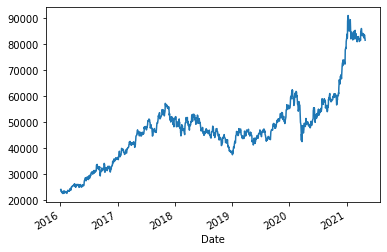

In [28]:
df['Close'].plot() #종가 그래프 
plt.show()

In [6]:
df.tail() #첫 다섯개 데이터 출력

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-26,83500.0,82600.0,82900.0,83500.0,15489938.0,83500.0
2021-04-27,83300.0,82500.0,83200.0,82900.0,12941533.0,82900.0
2021-04-28,83200.0,82100.0,83200.0,82100.0,15596759.0,82100.0
2021-04-29,82500.0,81500.0,82400.0,81700.0,20000973.0,81700.0
2021-04-30,82100.0,81500.0,81900.0,81500.0,18673197.0,81500.0


In [7]:
close_data = df['Close'].values # 종가데이터
volume_data = df['Volume'].values # 거래량데이터 
type(close_data)


numpy.ndarray

In [8]:
#데이터 정규화

close_mean = np.mean(close_data)
close_std = np.std(close_data)
print("종가 평균: %.2f  표준편차 %.2f" %(close_mean, close_std))
close_data = (close_data - close_mean)/close_std

volume_mean = np.mean(volume_data)
volume_std  = np.std(volume_data)
print("거래량 평균: %.2f  표준편차 %.2f" %(volume_mean, volume_std))
volume_data = (volume_data - volume_mean)/volume_std

종가 평균: 47571.67  표준편차 13814.06
거래량 평균: 14429407.35  표준편차 8274163.91


In [9]:
# 이전 prev 거래일 종가+거래량으로 다음 거래일 종가와 거래량 예측 
prev = 50
data_set = []
for i in range(len(close_data) - prev):
    x = np.concatenate((close_data[i:i+prev], volume_data[i:i+prev]))
    y = np.array([close_data[i+prev], volume_data[i+prev]])
    data_set.append([x, y])
print(len(data_set))

1252


In [10]:
# 정답이 제대로 입력되었는지 확인 
print(data_set[1][0][49])
print(data_set[0][1][0])

-1.6006644263060092
-1.6006644263060092


In [11]:
# training data, validation data, test data
np.random.shuffle(data_set)
split_ratio = 0.9
split_index = int(len(data_set)*split_ratio)
train_data = data_set[:split_index]
vt_data = data_set[split_index:]
valid_data = vt_data[:int(len(vt_data)/2)]
test_data = vt_data[int(len(vt_data)/2):]

print(len(train_data), len(valid_data), len(test_data))

1126 63 63


In [12]:
class net(torch.nn.Module):

    def __init__(self, prev):
        super(net, self).__init__()
        
        self.prev = 2*prev
        self.fc1    = nn.Linear(self.prev, self.prev*4) 
        self.fc2   = nn.Linear(self.prev*4, self.prev*4)
        self.fc3   = nn.Linear(self.prev*4, self.prev*4)
        self.fc4   = nn.Linear(self.prev*4, 2)
        
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self, data):
        data = np.array(data)
        data = np.concatenate(((data[:prev]-close_mean)/close_std,\
                              (data[prev:]-volume_mean)/volume_std)) 
        data = torch.from_numpy(data).float()
        forecast = self.forward(data).detach()
        forecast[0] = forecast[0]*close_std+ close_mean
        forecast[1] = forecast[1]*volume_std + volume_mean
        return list(forecast.numpy().astype(np.int32))

In [13]:
ANN = net(prev)

In [14]:
t = np.concatenate((df['Close'][-50:],df['Volume'][-50:]))
ANN.predict(t)

[48038, 14155030]

In [15]:
ANN.forward(torch.FloatTensor(t))

tensor([  185213.6719, -1100428.0000], grad_fn=<AddBackward0>)

In [16]:
_.detach()

tensor([  185213.6719, -1100428.0000])

In [17]:
class trainer:
    
    def __init__(self, net, lr, figname, train_data, v_data):
        
        self.net = net
        self.lrate = lr
        self.name = figname
        self.train_data = train_data
        self.valid_data = v_data
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lrate)
    
    def plot(self, train_loss, valid_loss):
        clear_output(True)
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title('train loss')
        plt.plot(train_loss, 'k-')
        plt.subplot(122)
        plt.title('valid loss')
        plt.plot(valid_loss)
        plt.savefig(self.name +'.png')
        plt.show()
    
    def train(self, epoch=10):
        
        train_loss_history = []
        valid_loss_history = []
        for j in range(epoch):
            
            self.optimizer.zero_grad()
            train_loss = 0
            for item in self.train_data:
                
                pred = self.net(torch.from_numpy(item[0]).float())
                target_v = torch.from_numpy(item[1]).float()
                train_loss += F.mse_loss(pred, target_v)
        
            train_loss.backward()
            self.optimizer.step()
            
            train_loss_history.append(train_loss.item())
                
            valid_loss = 0
            for item in self.valid_data:
                pred = self.net(torch.from_numpy(item[0]).float())
                target_v = torch.from_numpy(item[1]).float()
                valid_loss += F.mse_loss(pred, target_v)
            valid_loss_history.append(valid_loss.item())
        
            self.plot(train_loss_history, valid_loss_history)



In [18]:
ANN = net(prev)
tt = trainer(ANN, 1e-4, 'aaa', train_data, valid_data)

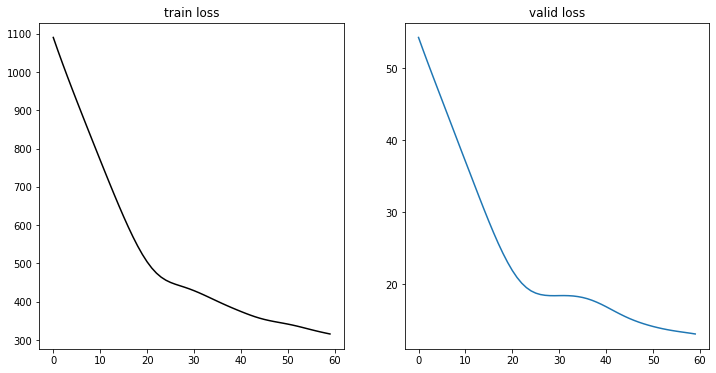

In [19]:
tt.train(60)

In [20]:
ANN.predict(t)

[83288, 14772113]

In [21]:
train_predict, train_actual = [], []
for item in train_data:
    price = ANN.forward(torch.FloatTensor(item[0]))
    train_predict.append(np.array(price.detach()[0]))
    train_actual.append(item[1][0])

train_predict = np.array(train_predict)
train_actual  = np.array(train_actual)
train_predict  = train_predict*close_std + close_mean
train_actual  = train_actual*close_std + close_mean

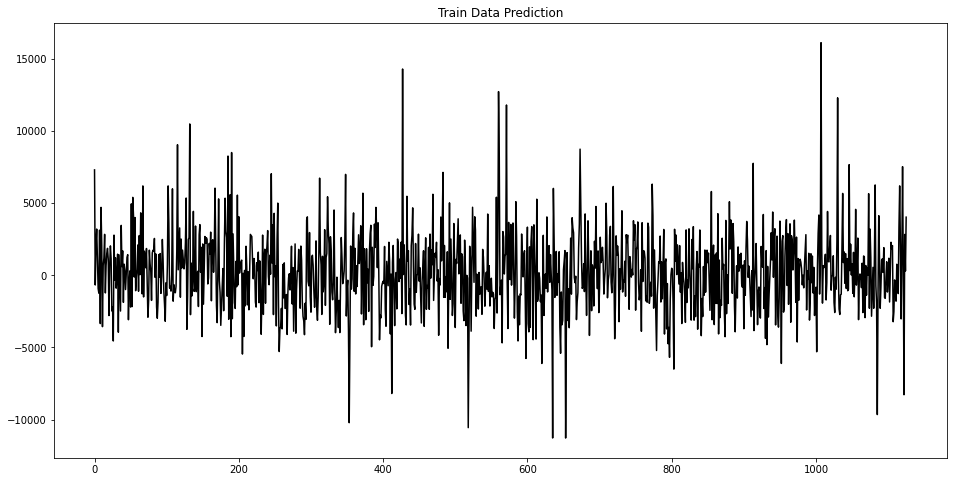

In [22]:
plt.figure(figsize=(16,8))
plt.title('Train Data Prediction')
#plt.plot(train_predict[:], 'k-')
#plt.plot(train_actual[:], 'r--')
plt.plot(train_actual-train_predict, 'k-')
plt.show()

In [23]:
valid_predict, valid_actual = [], []
for item in valid_data:
    price = ANN.forward(torch.FloatTensor(item[0]))
    valid_predict.append(np.array(price.detach()[0]))
    valid_actual.append(item[1][0])

valid_predict = np.array(valid_predict)
valid_actual  = np.array(valid_actual)
valid_predict  = valid_predict*close_std + close_mean
valid_actual  = valid_actual*close_std + close_mean

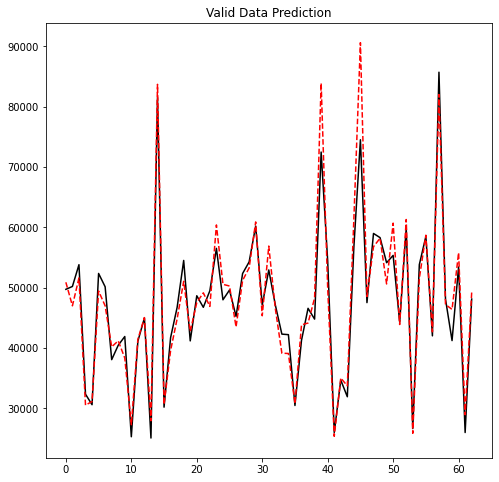

In [24]:
plt.figure(figsize=(8,8))
plt.title('Valid Data Prediction')
plt.plot(valid_predict[:], 'k-')
plt.plot(valid_actual[:], 'r--')

plt.show()

In [25]:
test_predict, test_actual = [], []
for item in test_data:
    price = ANN.forward(torch.FloatTensor(item[0]))
    test_predict.append(np.array(price.detach()[0]))
    test_actual.append(item[1][0])

test_predict = np.array(test_predict)
test_actual  = np.array(test_actual)
test_predict  = test_predict*close_std + close_mean
test_actual  = test_actual*close_std + close_mean

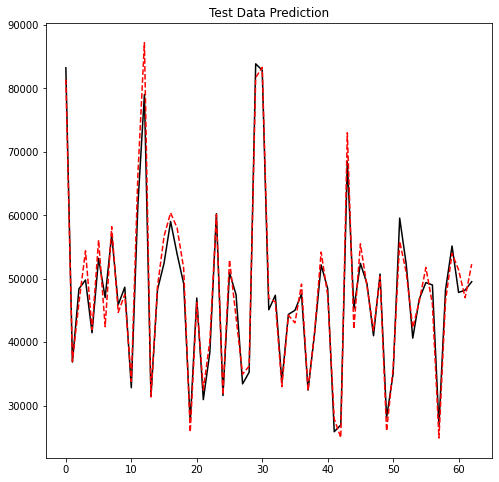

In [26]:
plt.figure(figsize=(8,8))
plt.title('Test Data Prediction')
plt.plot(test_predict[:], 'k-')
plt.plot(test_actual[:], 'r--')

plt.show()

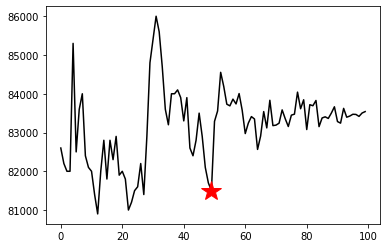

In [27]:
ff_price = list(df['Close'][-prev:])
ff_volume = list(df['Volume'][-prev:])

for _ in range(50):
    feed = np.array(ff_price[-prev:] + ff_volume[-prev:])
    forecast = ANN.predict(feed)
    ff_price += [forecast[0]]
    ff_volume += [forecast[1]]
    
plt.plot(ff_price,'k-')
plt.plot([prev-1],[ff_price[prev-1]],'r*', markersize =20 )
plt.show()